# enter model path

In [1]:
# path = '../log/geometric_graph/cube/checkpoints/best_model-step=14306.ckpt'
# path = '../log/geometric_graph/grid/checkpoints/best_model-step=26783.ckpt'
# path = '../log/geometric_graph/torus/checkpoints/best_model-step=19563.ckpt'
# path = '../log/geometric_graph/bunny/version_0/checkpoints/best_model-step=8080.ckpt'
# path = '../log/geometric_graph/line/version_1/checkpoints/best_model-step=4001.ckpt'
path = '../log/geometric_graph/cube8/version_3/checkpoints/best_model-step=31706.ckpt'

# import packages and load model

In [2]:
import sys
sys.path.append('../')

from utils.visualize import coord2scatter, plot_edge_index, plot_trend
from utils.utils import coord_invariant_rec_loss, damage_coord
from models import FixedTargetGAE

from pytorch_lightning.utilities.model_summary import ModelSummary
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook
import torch
print (f'cuda available? {torch.cuda.is_available()}')

device = 'cuda'

model = FixedTargetGAE.load_from_checkpoint(path).to(device)
print(ModelSummary(model, max_depth=1))

cuda available? True
  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | EncoderEGNCA | 5.3 K  | train
1 | mse     | MSELoss      | 0      | train
-------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


## notebook utils

In [11]:
box_dim = 1.0

coord_dim = model.encoder.coord_dim

def get_title(time_step, coord = None):
    title = '$t=%d$' % time_step
    if coord is not None:
        loss = coord_invariant_rec_loss(coord, model.target_coord)
        title += '$\quad \mathcal{L}_{\mathsf{INV}}=%.5f$' % loss
    return title

# initial and target geometric graphs

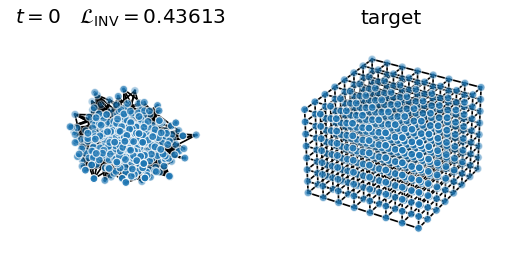

In [12]:
%matplotlib inline

fig = plt.figure(figsize=(8, 4), dpi=80)
fig.tight_layout()

ax1 = fig.add_subplot(121, projection='3d' if coord_dim == 3 else None)
ax2 = fig.add_subplot(122, projection='3d' if coord_dim == 3 else None)

coord2scatter(model.init_coord, title=get_title(0, model.init_coord), transparent=True, ax=ax1)
plot_edge_index(model.edge_index, coord=model.init_coord, title=get_title(0, model.init_coord), ax=ax1)
coord2scatter(model.target_coord, title='target', transparent=True, ax=ax2)
plot_edge_index(model.edge_index, coord=model.target_coord, title='target', ax=ax2)

plt.show()

# transition rule dynamics animation

100%|██████████| 50/50 [00:00<00:00, 1020.18it/s]


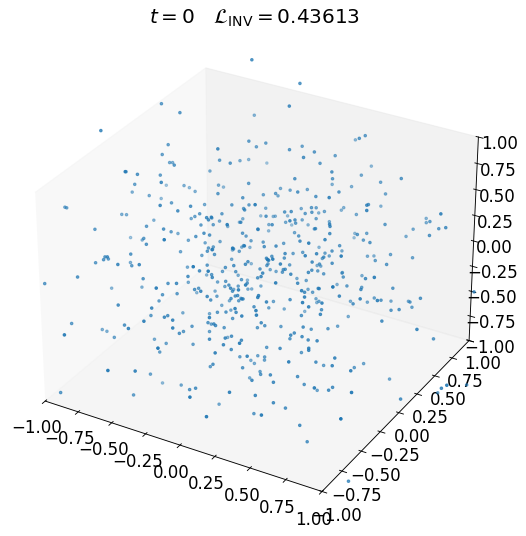

In [14]:
inter_coords, inter_node_feats = model.eval(n_steps=50, rotate=True, return_inter_states=True)

def animate(t):
    ax.clear()
    coord2scatter(inter_coords[t], box_dim=box_dim, ax=ax, title=get_title(t, inter_coords[t]))
    # plot_edge_index(model.edge_index, coord=inter_coords[t], box_dim=box_dim, ax=ax, title=get_title(t, inter_coords[t]))

fig = plt.figure(figsize=(8, 8), dpi=80)
fig.tight_layout()
ax = fig.add_subplot(projection='3d' if coord_dim == 3 else None)
ani = animation.FuncAnimation(fig, animate, frames=range(len(inter_coords)), interval=500, repeat=False)
ani.save('evolve-cube8.gif', dpi=80, writer=animation.PillowWriter(fps=5))

100%|██████████| 1000/1000 [00:00<00:00, 1098.47it/s]


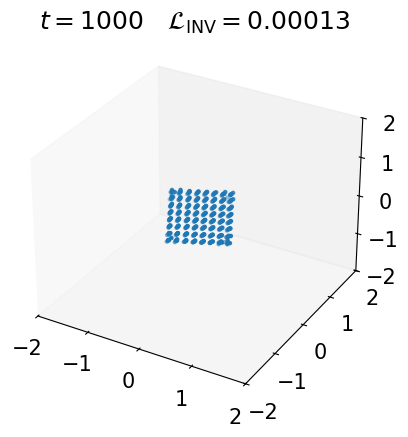

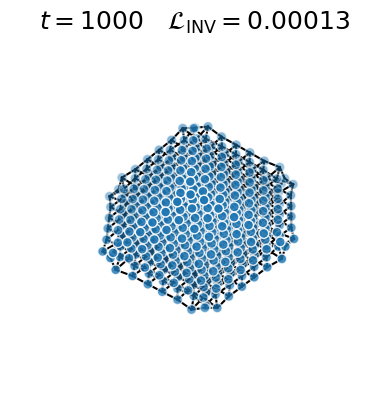

In [6]:
n_steps = 1000
final_coord, final_node_feat = model.eval(n_steps=n_steps, rotate=True)
coord2scatter(final_coord, title=get_title(n_steps, final_coord), box_dim=box_dim)
plot_edge_index(model.edge_index, coord=final_coord.detach().cpu().numpy(), title=get_title(n_steps, final_coord))

# regeneration

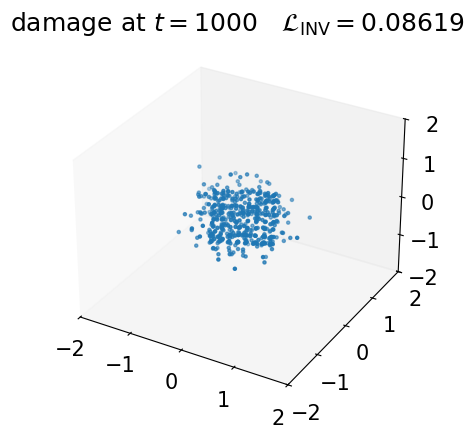

In [7]:
damaged_coord = damage_coord(final_coord, std=0.25, radius=1.0) # , radius=1.0
coord2scatter(damaged_coord, box_dim=box_dim, title='damage at ' + get_title(n_steps, damaged_coord))

100%|██████████| 20/20 [00:00<00:00, 1052.44it/s]


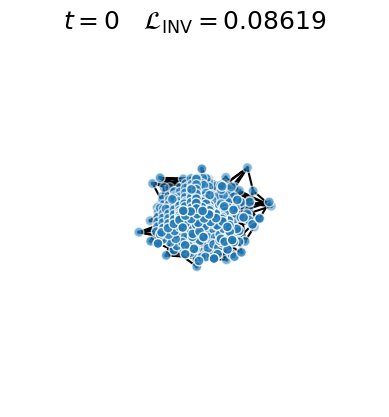

In [8]:
regenerated_coords = model.eval(
    n_steps=20, init_coord=damaged_coord, init_node_feat=final_node_feat, return_inter_states=True)[0]

def animate(t):
    ax.clear()
    coord2scatter(regenerated_coords[t].detach(), box_dim=box_dim, ax=ax, title=get_title(t, regenerated_coords[t]))
    plot_edge_index(model.edge_index, coord=regenerated_coords[t].detach().cpu().numpy(), box_dim=box_dim, ax=ax, title=get_title(t, regenerated_coords[t]))

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(projection='3d' if coord_dim == 3 else None)
ani = animation.FuncAnimation(fig, animate, frames=range(len(regenerated_coords)), interval=1000, repeat=False)
ani.save('regenerate-cube8-edges.gif', dpi=300, writer=animation.PillowWriter(fps=5))

100%|██████████| 3/3 [00:00<00:00, 749.88it/s]


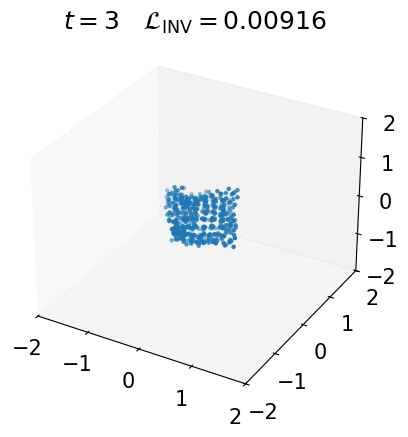

In [9]:
n_regeneration_steps = 3
regenerated_coord = model.eval(n_steps=n_regeneration_steps, init_coord=damaged_coord, init_node_feat=final_node_feat)[0]
coord2scatter(regenerated_coord, box_dim=box_dim, title=get_title(n_regeneration_steps, regenerated_coord))